# 5. Demodulation

In [1]:
%run pykat_notebook_defaults.py
pykat.init_pykat_plotting(dpi=90)

                                              ..-
    PyKat 0.8.3           _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,  
   `^-....____:   +.      www.gwoptics.org/pykat

Imported matplotlib.pyplot as plt
Imported numpy as np


You can now use 'show_finesse(kat)' to display the Finesse code of a 'kat' object


To extract information about the modulation mechanism, we use a technique called de-modulation. This can be done by using an electronic mixer and a low pass filter. Mathematically, the mixer multiplies the signal with a local oscillator, and the low pass filter filters out all nonzero frequencies. Lets go back to the field we create by the moving mirror, but we also need to assume that the phase modulation partly has been converted into amplitude modulation, for example by a Michelson. The field is described by

\begin{align}
E(t) = a_0 \mathrm{e}^{\omega_0 t} + a_-\mathrm{e}^{\omega_- t} + a_+ \mathrm{e}^{\omega_+ t},
\end{align}

where $\omega_\pm = \omega_0 \pm \Omega$, and $\Omega$ is the frequency of the mirror motion. The power seen by a photodiode at the reference plane would be

\begin{align}
S_0 = E(t) E^*(t) = \sum_j \sum_k a_j a_k^* \mathrm{e}^{i(\omega_j - \omega_k)t} ,
\end{align}


where the summations are over the three frequency components labeled by $0$, $-$, and $+$. By multiplying with a sinusoidal local oscillator with frequency $\omega_x$ and phase $\varphi_x$ we obtain

\begin{align}
S_1 &= \cos(\omega_x t + \varphi_x) S_0  \\ 
    &= \frac{1}{2}\Big(\mathrm{e}^{i(\omega_x t+\varphi_x)} + \mathrm{e}^{-i(\omega_x t+\varphi_x)} \Big) \sum_j \sum_k a_j a_k^* \mathrm{e}^{i(\omega_j - \omega_k)t} \\
    &= \frac{1}{2} \sum_j \sum_k a_j a_k^* \Big[ \mathrm{e}^{i\left( (\omega_j-\omega_k + \omega_x)t + \varphi_x \right)} + \mathrm{e}^{i\left( (\omega_j-\omega_k - \omega_x)t - \varphi_x \right)} \Big] .
\end{align}

If we set the de-modulation frequency to be the same as the modulation frequency, i.e. $\omega_x = \Omega$, the DC part becomes

\begin{align}
S_{1,DC} &= \frac{1}{2} \Big[ a_0 a_{-}^* \mathrm{e}^{-i\varphi_x} + a_0^* a_- \mathrm{e}^{i\varphi_x} + a_0 a_{+}^* \mathrm{e}^{i\varphi_x} + a_0^* a_+ \mathrm{e}^{-i\varphi_x}\Big] \\
         &= \mathcal{Re} \Big\{ a_0a_-^*\mathrm{e}^{-i\varphi_x} + a_0^* a_+ \mathrm{e}^{-i\varphi_x} \Big\}
\end{align}

We see that we can use the de-modulation phase $\varphi_x$ to optimise the output. Or we can use two mixers: one with $\varphi_x = 0$ and one with $\varphi_x=\pi/2$ to extract the full phase and amplitude information of our sidebands. By doing this we could obtain
​
\begin{align}
S_{1,DC} = a_0a_-^* + a_0^* a_+.
\end{align}

Thus, we have the amplitude and phase information of the the beat signal! If we know our system, we can then trace this back to get information about the mechanism that created the origianl phase modulation.

### Finesse example: electro-optic modulator and demodulation
In this Finesse example a carrier field is modulated by using an electro-optic modulator (EOM) (keyword `mod`). The power is measured by a photodiode, and this power signal is demodulated by using three different demodulation phases: one detector with $\varphi_x = 0$, another with $\varphi = 90$ degrees, and a third with the optimal demodulation phase, here $\varphi_x = 20$ degrees.  While doing this, we are varying the modulation index of the EOM.

In [2]:
kat = finesse.kat()          # Initialising Finesse
kat.verbose = False          # Tells Finesse to talk less

code = """
## The optical system ##
l laser 1 0 n0                # Laser with 0 offset wavelength (thus default 1064nm used)
s s1 1 n0 n1                  # Space from laser to mirror (1 m)
mod eom 1k 0.3 2 am 20 n1 n2  # Modulator (f=1 kHz, m=0.3, 2 sideband pairs, amplitude modulation, phase=20 degrees)
s s2 1 n2 n3                  # Space from modulator to output (1 m)

## Detectors ##
pd dc n3                # Photodiode and a low pass filter
pd1 inphase 1k 0 n3     # Photodiode, mixer and low pass filter (demod f = 1kHz, demod phase = 0)
pd1 quad 1k 90 n3       # Photodiode, mixer and low pass filter (demod f = 1kHz, demod phase = 90 degrees)
pd1 max 1k max n3       # Photodiode, mixer and low pass filter (demod f = 1kHz, demod phase = optimised (max) )

## Instructions ##
xaxis eom midx lin 0 1 200   # Varying the modulation index of the modulator between 0 and 1.
yaxis abs                # Allowing outputs to be complex numbers
"""

# Parsing the code and running the simulation
kat.parseCommands(code)
out = kat.run()

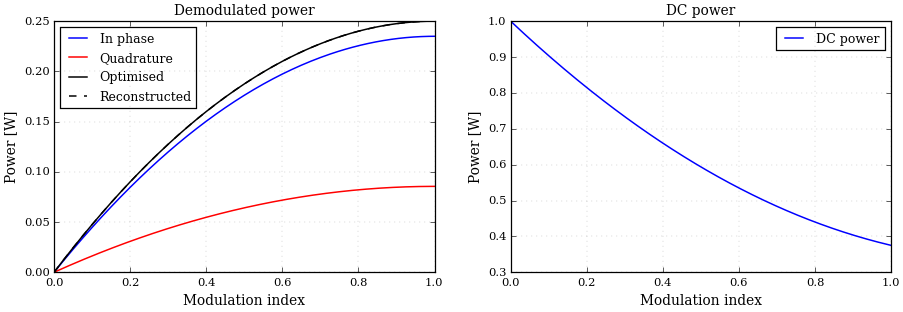

In [3]:
# Reconstructing full amplitude and phase information
tot = out['inphase'] + 1j*out['quad']

## Plotting ##

fig = pykat.plotting.figure(textwidth=12, height=0.3)
ax = plt.subplot(1,2,1)
ax.plot(out.x, out['inphase'], label='In phase')
ax.plot(out.x, out['quad'], label='Quadrature')
ax.plot(out.x, out['max'], label='Optimised')
ax.plot(out.x, np.abs(tot), '--k', label='Reconstructed')
ax.set_xlabel('Modulation index')
ax.set_ylabel('Power [W]')
ax.set_title('Demodulated power', size=11)
ax.legend(loc=0, fontsize=10)

ax = plt.subplot(1,2,2)
ax.plot(out.x, out['dc'],label='DC power')

ax.set_xlabel('Modulation index')
ax.set_ylabel('Power [W]')
ax.set_title('DC power', size=11)
ax.legend(loc=0, fontsize=10)

plt.show()

<font size="2">**Figure.** The left figure shows three traces with different demodulation phases $\varphi_x$. The one called in phase has $\varphi_x = 0$ and the one called quadrature has $\varphi_x = \pi/2~ (=90~\mathrm{degrees})$. For the trace called optimise we used the keywordb `max`, which tells Finesse to use the demodulation phase that yields the largest output. In this case this is obtained with $\varphi_x = 20$ degrees. We also show that the optimised result can be reconstucted by using two 'in phase' and 'quadrature'. The right figure shows that the DC power drops with increased modulation index, which is consistent with energy going from the carrier field into the sidebands, which gives rise to the oscilating beat signal.</font>

In this example we see that we can use demodulation to reconstruct the amplitude of the beat signal by combining the result obtained by two different demdulation phases that shifted 90 degrees compared to each other. In Finesse, we can also cheat and set the demodulation phase to `max`, which gives the same result. In the right figure we see that the DC power drops as the modulation index increases, i.e., more and more of the energy goes into the beat signal. 

You can try to change the amplitude modulation into phase modulation and see what happens. This can be done by changing the `EOM` paramter `am` into `phase`.

**Summary:** Demodulation can be used to extract the amplitude and phase of a 'beat' present in a power signal. In gravitational wave detectors, modulation-demodulation schemes are used for sensing the cavity lengths.